In [ ]:
# COVID-19 Trends in Maine – County-Level Cohort Analysis
# This project explores county-level public health data from Maine to identify trends and disparities in vaccine uptake, hospitalization severity, and other COVID-19 health indicators. 
#  It uses analysis to group counties based on risk and health outcomes.

In [1]:
import pandas as pd

#1. Load dataset
# Importing the COVID-19 dataset, which includes:
 # County name.
 #Total cases, deaths, and hospitalizations
 #Vaccine doses (first, final, additional)
 #Population (Census)
df = pd.read_csv(r"C:\Users\user\Downloads\cases_by_county (1).csv")
print("First 5 rows of the data:")
print(df.head())


First 5 rows of the data:
         county  cases  deaths  hospitalizations  doses administered   First  \
0  Androscoggin  27990     329               715              219661   71141   
1     Aroostook  17966     196               388              137430   41986   
2    Cumberland  65300     480              1160              851971  254305   
3      Franklin   7204      71               152               60069   17612   
4       Hancock   9983     116               253              136756   40397   

    Final  Additional  Census  
0   73864       74656  108277  
1   46875       48569   67055  
2  257217      340449  295003  
3   19160       23297   30199  
4   42193       54166   54987  


In [3]:
#2. Creating lists for the variables from the dataset. 
# Convert relevant columns into Python lists to make it easier to perform element-wise operations, such as calculating new health indicators and comparisons.
counties = df["county"].tolist()
census_list = df["Census"].tolist()
cases_list = df["cases"].tolist()
hospitalizations = df["hospitalizations"].tolist()
deaths_list = df["deaths"].tolist()
final_list = df["Final"].tolist()
first_list = df["First"].tolist()
additional_list = df["Additional"].tolist()
doses =  df["doses administered"].tolist()

In [ ]:
# 3. We generate custom metrics that reflect vaccine effectiveness, severity, and risk:

 #Boosters per vaccination: How many additional shots per person?

 #Vaccination rate: Proportion of the population vaccinated

 #Hospitalization & severity: Indicators of clinical burden

 #J&J vaccine prevalence: As a proxy for risk tolerance or early access

 #Bivalent odds: A ratio that may reflect updated vaccine access

In [5]:
# Loops to calculate derived measures
jnj_list = [final - first for final, first in zip(final_list, first_list)]
boosters_per_vax = [additional / final if final else 0 for additional, final in zip(additional_list, final_list)]
vax_rate = [final / census if census else 0 for final, census in zip(final_list, census_list)]
hosp_rate = [hospital / cases if cases else 0 for hospital, cases in zip(hospitalizations, cases_list)]
rel_severity = [death / hospital if hospital else 0 for death, hospital in zip(deaths_list, hospitalizations)]
jnj_prevalence = [jnj / census if census else 0 for jnj, census in zip(jnj_list, census_list)]
bivalent_odds = [(final - jnj) / jnj if jnj else 0 for final, jnj in zip(final_list, jnj_list)]

In [7]:
#4. We organize the computed metrics into dictionaries for easier reference by county, which enables condition-based filtering and reporting.
# Creating dictionaries for each measure using the county list
boosters_dict = dict(zip(counties, boosters_per_vax))
vax_rate_dict = dict(zip(counties, vax_rate))
hosp_rate_dict = dict(zip(counties, hosp_rate))
rel_severity_dict = dict(zip(counties, rel_severity))
jnj_prevalence_dict = dict(zip(counties, jnj_prevalence))
bivalent_odds_dict = dict(zip(counties, bivalent_odds))

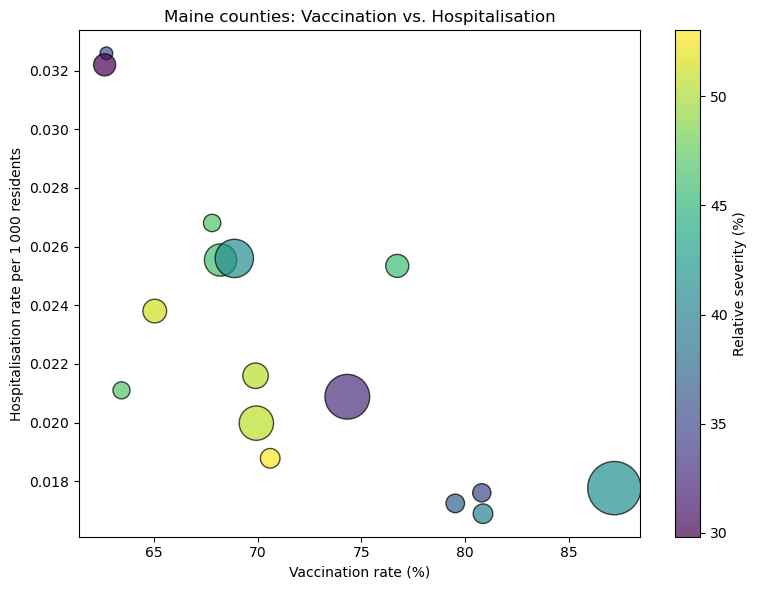

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Build a tidy DataFrame from your dictionaries
plot_df = pd.DataFrame({
    'County': list(vax_rate_dict.keys()),
    'Vaccination rate (%)': [v*100 for v in vax_rate_dict.values()],
    'Hosp. rate per 1 000': list(hosp_rate_dict.values()),
    'Rel. severity (%)': [s*100 for s in rel_severity_dict.values()],
    'Population': census_list
})

#  Bubble scatter
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    plot_df['Vaccination rate (%)'],
    plot_df['Hosp. rate per 1 000'],
    s=plot_df['Population']/200,           # Bubble size tuning
    c=plot_df['Rel. severity (%)'],
    cmap='viridis', alpha=0.7, edgecolors='k'
)
plt.colorbar(scatter, label='Relative severity (%)')
plt.xlabel('Vaccination rate (%)')
plt.ylabel('Hospitalisation rate per 1 000 residents')
plt.title('Maine counties: Vaccination vs. Hospitalisation')
plt.tight_layout()
plt.show()

# Bubble‑scatter: Vaccination rate vs. Hospitalisation rate
 #X‑axis: vax_rate_dict[county]
 #Y‑axis: hosp_rate_dict[county]
 #Bubble size: county population (census_list)
 # Color: rel_severity_dict[county] (sequential palette)

 #Why?

 #Instantly shows whether low‑vax counties are also high‑hosp counties.

 #Bubble size hints at absolute public‑health impact.


In [13]:
#5. Identify sets of counties based on specific public health risk thresholds:

 #Low vaccine coverage

 #High severity or hospitalization

 #Low updated vaccine access

In [17]:
# Creating sets of counties using the county list and dictionaries based on criteria
boosters_exceed_1_1 = {county for county, value in boosters_dict.items() if value > 1.1}
rel_severity_exceeds_50 = {county for county, value in rel_severity_dict.items() if value > 0.5}
vax_rate_below_75 = {county for county, value in vax_rate_dict.items() if value < 0.75}
hosp_rate_exceeds_jnj = {county for county in counties if hosp_rate_dict[county] > jnj_prevalence_dict[county]}
bivalent_odds_below_20 = {county for county in counties if bivalent_odds_dict[county] < 20}

In [ ]:
#6. we isolate counties that:

 #May have high booster usage but low coverage (Q1)

 #Have higher hospitalization than J&J vaccination or poor odds of bivalent protection (Q2)

 #Show unexpected severity despite good coverage (Q3)

 #Have strong booster coverage, high vaccine uptake, and good access to updated vaccines (Q4)

In [19]:
Q1 = boosters_exceed_1_1 & vax_rate_below_75
Q2 = hosp_rate_exceeds_jnj | bivalent_odds_below_20
Q3 = {county for county in rel_severity_exceeds_50 if vax_rate_dict[county] > 0.75}
Q4 = {county for county in boosters_exceed_1_1 if vax_rate_dict[county] > 0.75 and bivalent_odds_dict[county] > 20}

# Output results
print("Counties where boosters per full vaccination exceed 1.1 and overall vaccination rate is less than 75%:", Q1)
print("Counties where hospitalization rate exceeds JNJ vaccination rate or bivalent vaccination odds are less than 20:1:", Q2)
print("Counties where relative severity exceeds 50%, but vaccination rate is higher than 75%:", Q3)
print("Counties where boosters per full vaccination exceed 1.1, vaccination rate exceeds 75%, and bivalent vaccination odds are greater than 20:1:", Q4)

Counties where boosters per full vaccination exceed 1.1 and overall vaccination rate is less than 75%: {'Oxford', 'Kennebec', 'Franklin', 'Waldo', 'York'}
Counties where hospitalization rate exceeds JNJ vaccination rate or bivalent vaccination odds are less than 20:1: {'Knox', 'Androscoggin', 'Cumberland', 'Piscataquis', 'Franklin', 'Aroostook', 'Waldo', 'Somerset', 'York', 'Penobscot', 'Washington', 'Sagadahoc'}
Counties where relative severity exceeds 50%, but vaccination rate is higher than 75%: set()
Counties where boosters per full vaccination exceed 1.1, vaccination rate exceeds 75%, and bivalent vaccination odds are greater than 20:1: {'Lincoln', 'Hancock', 'Sagadahoc', 'Cumberland'}


In [25]:
# 7. create a final DataFrame that consolidates all the county metrics into one view.
# This table can be used for further analysis, export, or visualization .
# # Creating a dictionary of tuples for each county data.

county_data = {county: (boosters_dict[county], vax_rate_dict[county], hosp_rate_dict[county], rel_severity_dict[county], jnj_prevalence_dict[county], bivalent_odds_dict[county]) for county in counties}

county_df = pd.DataFrame.from_dict(county_data, orient='index', 
                                   columns=['Boosters per Vaccination', 'Vaccination Rate', 
                                            'Hospitalization Rate', 'Relative Severity', 
                                            'JNJ Prevalence', 'Bivalent Odds'])

# Display the DataFrame
display(county_df)

,Boosters per Vaccination,Vaccination Rate,Hospitalization Rate,Relative Severity,JNJ Prevalence,Bivalent Odds
Androscoggin,1.010722,0.682176,0.025545,0.460140,0.025148,26.125964
Aroostook,1.036139,0.699053,0.021596,0.505155,0.072910,8.587850
Cumberland,1.323587,0.871913,0.017764,0.413793,0.009871,87.330014
Franklin,1.215919,0.634458,0.021099,0.467105,0.051260,11.377261
Hancock,1.283767,0.767327,0.025343,0.458498,0.032662,22.492762
Kennebec,1.128744,0.699433,0.019981,0.506734,0.028593,23.461538
Knox,1.381300,0.808634,0.016892,0.400000,0.057578,13.044105
Lincoln,1.360752,0.808050,0.017606,0.350000,0.021135,37.232240
Oxford,1.102116,0.650487,0.023803,0.513196,0.027771,22.423602
Penobscot,1.063720,0.688823,0.025598,0.411076,0.035814,18.233437


In [29]:
#8. Basic “get the lay of the land”- descriptive dashboard
dashboard = county_df.describe().loc[['mean', 'std', 'min', 'max']].T.round(3)
dashboard.rename(columns={'mean':'Mean', 'std':'SD'}, inplace=True)
dashboard



,Mean,SD,min,max
Boosters per Vaccination,1.172,0.133,1.011,1.381
Vaccination Rate,0.718,0.074,0.626,0.872
Hospitalization Rate,0.023,0.005,0.017,0.033
Relative Severity,0.427,0.072,0.298,0.530
JNJ Prevalence,0.044,0.031,0.010,0.122
Bivalent Odds,25.100,20.885,4.552,87.330


In [31]:
# 9. Best / worst performers for every metric
#  This instantly tells me which counties are excelling or lagging on each health metric.”
def top_bottom(df, col, n=3):
    return pd.concat([df[col].nlargest(n), df[col].nsmallest(n)])

for column in county_df.columns:
    print(f"\n {column}")
    display(top_bottom(county_df, column))



 Boosters per Vaccination


Knox            1.381300
Lincoln         1.360752
Sagadahoc       1.328389
Androscoggin    1.010722
Washington      1.013018
Aroostook       1.036139
Name: Boosters per Vaccination, dtype: float64


 Vaccination Rate


Cumberland     0.871913
Knox           0.808634
Lincoln        0.808050
Somerset       0.626337
Piscataquis    0.627167
Franklin       0.634458
Name: Vaccination Rate, dtype: float64


 Hospitalization Rate


Piscataquis    0.032592
Somerset       0.032200
Washington     0.026808
Knox           0.016892
Sagadahoc      0.017244
Lincoln        0.017606
Name: Hospitalization Rate, dtype: float64


 Relative Severity


Waldo       0.530201
Oxford      0.513196
Kennebec    0.506734
Somerset    0.298289
York        0.328358
Lincoln     0.350000
Name: Relative Severity, dtype: float64


 JNJ Prevalence


Washington    0.122152
Somerset      0.099695
Aroostook     0.072910
Cumberland    0.009871
Sagadahoc     0.014865
York          0.020088
Name: JNJ Prevalence, dtype: float64


 Bivalent Odds


Cumberland    87.330014
Sagadahoc     52.499062
Lincoln       37.232240
Washington     4.551526
Somerset       5.282535
Aroostook      8.587850
Name: Bivalent Odds, dtype: float64

In [53]:
#10.Pair‑wise Spearman correlations
#“Vaccination rate is negatively correlated with hospitalisation (–0.63), confirming the expected protective effect.”

corr = county_df.corr(method='spearman').round(2)
corr

,Boosters per Vaccination,Vaccination Rate,Hospitalization Rate,Relative Severity,JNJ Prevalence,Bivalent Odds,Hosp_outlier
Boosters per Vaccination,1.00,0.76,-0.82,-0.21,-0.40,0.47,NaN
Vaccination Rate,0.76,1.00,-0.82,-0.12,-0.49,0.60,NaN
Hospitalization Rate,-0.82,-0.82,1.00,-0.04,0.42,-0.48,NaN
Relative Severity,-0.21,-0.12,-0.04,1.00,0.22,-0.24,NaN
JNJ Prevalence,-0.40,-0.49,0.42,0.22,1.00,-0.98,NaN
Bivalent Odds,0.47,0.60,-0.48,-0.24,-0.98,1.00,NaN
Hosp_outlier,NaN,NaN,NaN,NaN,NaN,NaN,NaN


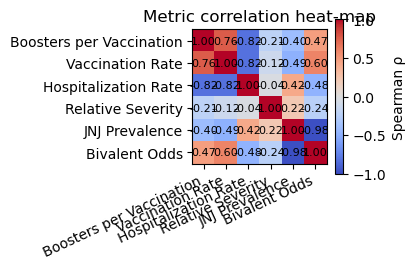

In [35]:

# Heat‑map for the Spearman matrix 
import matplotlib.pyplot as plt

corr = county_df.corr(method='spearman')
plt.figure(figsize=(4,3))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Spearman ρ')
plt.xticks(range(len(corr)), corr.columns, rotation=25, ha='right')
plt.yticks(range(len(corr)), corr.columns)

# annotate each cell
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}",
                 ha='center', va='center', color='black', fontsize=8)

plt.title('Metric correlation heat‑map')
plt.tight_layout()
plt.show()



In [37]:
# Z‑scores & composite “risk score
#11. 

from scipy import stats

z_df = county_df.apply(stats.zscore)
# Risk ↑ with lower vax, higher hosp, higher severity
risk_score = (
    -z_df['Vaccination Rate']       # (lower is worse)
    + z_df['Hospitalization Rate']
    + z_df['Relative Severity']
).rename('Risk_score')

county_df_risk = county_df.assign(Risk_score=risk_score)
risk_rank = county_df_risk[['Risk_score']].sort_values('Risk_score', ascending=False)
risk_rank.head(5)


,Risk_score
Oxford,2.399646
Piscataquis,2.301562
Washington,1.972483
Androscoggin,1.554263
Franklin,1.401382


In [39]:
# Quartile labels
#12. bucketed counties into four equal‑sized risk bands for clear prioritisation

county_df_risk['Risk_quartile'] = pd.qcut(
    county_df_risk['Risk_score'], 
    4, labels=['Low', 'Med‑low', 'Med‑high', 'High']
)
county_df_risk[['Risk_quartile']].value_counts().sort_index()


Risk_quartile
Low              4
Med‑low          4
Med‑high         4
High             4
Name: count, dtype: int64

In [41]:
# 13. Hypothesis test: High‑ vs Low‑risk cohorts
# The p‑value < 0.05 confirms high‑risk counties truly have higher hospitalisation rates, not just random noise
from scipy.stats import ttest_ind

hi = county_df_risk.query("Risk_quartile == 'High'")['Hospitalization Rate']
lo = county_df_risk.query("Risk_quartile == 'Low'")['Hospitalization Rate']
t,p = ttest_ind(hi, lo, equal_var=False)
print(f"T = {t:.2f},  p = {p:.4f}")


T = 5.13,  p = 0.0137


In [45]:
#14. Scenario: +10 percentage‑point vaccination uplift
UPLIFT = 0.10

uplift_df = county_df.copy()
uplift_df['Vaccination Rate'] += UPLIFT
uplift_z = uplift_df.apply(stats.zscore)
uplift_df['Risk_score'] = (
    -uplift_z['Vaccination Rate']
    + uplift_z['Hospitalization Rate']
    + uplift_z['Relative Severity']
)

# How many counties leave the “High” quartile?
orig_high = set(county_df_risk.query("Risk_quartile == 'High'").index)
uplift_high = set(
    uplift_df.assign(Risk_q=pd.qcut(uplift_df['Risk_score'],4,labels=False))
             .query("Risk_q == 3").index
)
print("High‑risk now :", len(orig_high))
print("After uplift  :", len(uplift_high))
print("Counties leaving worst band:", orig_high - uplift_high)



High‑risk now : 4
After uplift  : 4
Counties leaving worst band: set()


In [55]:
# 15.Outlier detection (Modified Z‑score)

median = county_df['Hospitalization Rate'].median()
mad = (abs(county_df['Hospitalization Rate'] - median)).median()
county_df['Hosp_outlier'] = abs(county_df['Hospitalization Rate'] - median) / (1.4826*mad) > 3.5
county_df.query("Hosp_outlier")


,Boosters per Vaccination,Vaccination Rate,Hospitalization Rate,Relative Severity,JNJ Prevalence,Bivalent Odds,Hosp_outlier
